In [ ]:
!pip install category_encoders

In [ ]:
!pip install neptune-client

In [ ]:
!pip install scikitplot

ERROR: Could not find a version that satisfies the requirement scikitplot (from versions: none)
ERROR: No matching distribution found for scikitplot


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from imblearn.combine import SMOTETomek
from datetime import datetime
from sklearn.compose import ColumnTransformer

from sklearn.metrics import classification_report, make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold

from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform
import matplotlib.pyplot as plt

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import xgboost as xgb

from sklearn.model_selection import train_test_split

from sklearn.metrics import plot_confusion_matrix


In [ ]:
import neptune

API_TOKEN='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiYmM4OTBkYTAtY2JlYi00MGM4LWIzZTUtYzg1MTJkMzJkYjk3In0=' #@param {type:"string"}

PROJEKT_NAME = 'DataWorkshop-Foundation/Predicting-cancellation-of-visit' 

neptune.init(
   api_token=API_TOKEN,
   project_qualified_name=PROJEKT_NAME
)

Project(DataWorkshop-Foundation/Predicting-cancellation-of-visit)

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cancellation/data/KaggleV2-May-2016.csv')
dataset.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [ ]:
#patientID
dataset['PatientId'] = dataset['PatientId'].astype('int64') 

#AppointmentID
dataset.drop(dataset[dataset['AppointmentID'].isna()].index, inplace = True)

#gender
dataset['Gender'] = dataset['Gender'].map({'F':1, 'M':0})

#neiberhood

import category_encoders as ce

encoder = ce.OneHotEncoder(cols=['Neighbourhood'])
dataset = encoder.fit_transform(dataset)

#Age

dataset = dataset[dataset['Age'] >=0]

#no-show
dataset['No-show'] = dataset['No-show'].map({'Yes':1, 'No':0})

#date
dataset['ScheduledDay'] = dataset['ScheduledDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
dataset['ScheduledDay'] = dataset['ScheduledDay'].apply(lambda x: datetime.timestamp(x))

dataset['AppointmentDay'] = dataset['AppointmentDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
dataset['AppointmentDay'] = dataset['AppointmentDay'].apply(lambda x: datetime.timestamp(x))



/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
Y = dataset["No-show"]
Y.tail()

110522    0
110523    0
110524    0
110525    0
110526    0
Name: No-show, dtype: int64

In [ ]:
X = dataset.loc[:, dataset.columns != 'No-show']
X.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_48,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
110522,2572134369293,5651768,1,1.462267e+09,1.465258e+09,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
110523,3596266328735,5650093,1,1.462260e+09,1.465258e+09,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
110524,15576631729893,5630692,1,1.461773e+09,1.465258e+09,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
110525,92134931435557,5630323,1,1.461770e+09,1.465258e+09,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
110526,377511518121127,5629448,1,1.461764e+09,1.465258e+09,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
x, x_val, y, y_val = train_test_split(X, Y, test_size=0.1, train_size=0.9, random_state=0, stratify=Y, shuffle=True)

In [ ]:
dataset = x

In [ ]:
dataset['No-show'] =y

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
64281,468148177676828,5401357,0,1.456482e+09,1.464048e+09,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
42103,74734263232929,5612074,1,1.461571e+09,1.463357e+09,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
98202,79722691475274,5682365,0,1.462897e+09,1.464826e+09,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
58061,143523574527737,5744655,1,1.464604e+09,1.464566e+09,29,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
86,3376224477447,5595347,0,1.460983e+09,1.461888e+09,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48967,27259357386825,5545622,1,1.459866e+09,1.462234e+09,60,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
65595,8546883619353,5608251,1,1.461159e+09,1.463357e+09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66429,59578539883535,5604809,1,1.461140e+09,1.462752e+09,65,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
80281,3412872332627,5667202,0,1.462520e+09,1.462493e+09,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
X = dataset.loc[:, dataset.columns != 'No-show']
X.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_48,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
48967,27259357386825,5545622,1,1.459866e+09,1.462234e+09,60,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1
65595,8546883619353,5608251,1,1.461159e+09,1.463357e+09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66429,59578539883535,5604809,1,1.461140e+09,1.462752e+09,65,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
80281,3412872332627,5667202,0,1.462520e+09,1.462493e+09,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
16592,657597498615,5603279,1,1.461088e+09,1.462320e+09,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
Y = dataset["No-show"]
Y.tail()

48967    0
65595    0
66429    0
80281    0
16592    1
Name: No-show, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, train_size=0.9, random_state=0, stratify=Y, shuffle=True)

In [ ]:
def model(X_train, y_train, X_test,y_test, search, name, tags):
  
  #print(search.get_params())
  # y_train = train["NoShow"]
  # y_test = test["NoShow"]

  # X_train = train.loc[:, train.columns != 'NoShow']
  # X_test = test.loc[:, test.columns != 'NoShow']
                
  search = search.fit(X_train, y_train)

  #search.best_params_

  y_pred = search.predict(X_test)
  print(y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  print(' f1 ', f1_score(y_test, y_pred), '\n',
        'recall', recall_score(y_test, y_pred), '\n',
        'precision', precision_score(y_test, y_pred) )

  neptune.create_experiment(
      name=name
  )

  neptune.log_metric('accuracy', accuracy)
  neptune.log_metric('f1', f1_score(y_test, y_pred))
  neptune.log_metric('recall', recall_score(y_test, y_pred))
  neptune.log_metric('precision', precision_score(y_test, y_pred))
  neptune.append_tags(tags)
  neptune.append_tags(["Magdalena Cebula"])
  #neptune.append_tags([str(space4dt)])
  from sklearn.metrics import confusion_matrix

  conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
  print('Confusion matrix:\n', conf_mat)

  from matplotlib import pyplot as plt

  labels = ['Class 0', 'Class 1']
  fig = plt.figure()
  ax = fig.add_subplot()
  cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  plt.show()

  neptune.log_image('Confusion_matrix ' + name, fig)
  
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, search.predict(X_test))
  print(false_positive_rate, true_positive_rate, thresholds)


  roc_auc_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)
  neptune.log_metric('roc_auc', auc)
  fig = plt.figure()
  plt.plot(false_positive_rate,true_positive_rate,label="data 1, auc="+str(auc))
  plt.legend(loc=4)
  plt.show()
  neptune.log_image('ROC AUC ' + name, fig)
  neptune.stop()

In [ ]:
clf =  xgb.XGBClassifier(random_state=0)

In [ ]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

[0 0 0 ... 0 0 0]
Accuracy: 79.83%
 f1  0.007909045971329708 
 recall 0.003982080637132902 
 precision 0.5714285714285714
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-568
Confusion matrix:
 [[7933    6]
 [2001    8]]


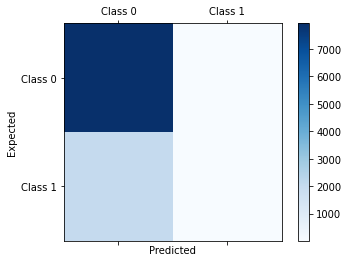

[0.00000000e+00 7.55762691e-04 1.00000000e+00] [0.         0.00398208 1.        ] [2 1 0]


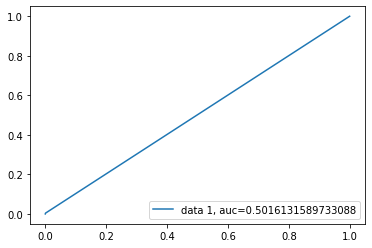

In [ ]:
model(X_train, y_train, X_test,y_test, clf, 'XGBClassifier', ['XGBClassifier', 'Raw', 'EDA2'])

In [ ]:
#smotetomek
X = dataset.loc[:, dataset.columns != 'No-show']
Y = dataset["No-show"]

smote_tomek = SMOTETomek(random_state=0)
X_smote, y_smote = smote_tomek.fit_resample(X, Y)



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
NoShow = pd.DataFrame(data = X_smote, columns = X.columns)
YNoShow = pd.DataFrame(data = y_smote, columns = ["No-show"])
NoShow["No-show"] = YNoShow


In [ ]:
NoShow

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,4.681482e+14,5.401357e+06,0.000000,1.456482e+09,1.464048e+09,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0
1,7.473426e+13,5.612074e+06,1.000000,1.461571e+09,1.463357e+09,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1
2,7.972269e+13,5.682365e+06,0.000000,1.462897e+09,1.464826e+09,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0
3,9.413494e+13,5.640253e+06,1.000000,1.461925e+09,1.463098e+09,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1
4,3.881118e+13,5.647384e+06,0.000000,1.462196e+09,1.464826e+09,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4.975920e+12,5.639329e+06,1.000000,1.461920e+09,1.464908e+09,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.997916,0.0,0.0,0.000000,0.002084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
def split_and_model(data, tags):
  X = data.loc[:, data.columns != 'No-show']
  X.tail()
  Y = data["No-show"]
  Y.tail()
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, train_size=0.9, random_state=0, stratify=Y, shuffle=True)
  model(X_train, y_train, X_test,y_test, clf, 'XGBClassifier', tags)


In [ ]:
dataset=NoShow

In [ ]:
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,4.681482e+14,5.401357e+06,0.000000,1.456482e+09,1.464048e+09,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0
1,7.473426e+13,5.612074e+06,1.000000,1.461571e+09,1.463357e+09,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1
2,7.972269e+13,5.682365e+06,0.000000,1.462897e+09,1.464826e+09,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0
3,9.413494e+13,5.640253e+06,1.000000,1.461925e+09,1.463098e+09,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1
4,3.881118e+13,5.647384e+06,0.000000,1.462196e+09,1.464826e+09,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4.975920e+12,5.639329e+06,1.000000,1.461920e+09,1.464908e+09,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.997916,0.0,0.0,0.000000,0.002084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
#date
dataset['ScheduledDay'] =  dataset['ScheduledDay'].apply(lambda x: datetime.fromtimestamp(x))
dataset['AppointmentDay'] =  dataset['AppointmentDay'].apply(lambda x: datetime.fromtimestamp(x))

In [ ]:
dataset['Waiting_Time_days'] = dataset['AppointmentDay'] - dataset['ScheduledDay']
dataset['Waiting_Time_days'] = dataset['Waiting_Time_days'].dt.days
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days
0,4.681482e+14,5.401357e+06,0.000000,2016-02-26 10:14:28.000000,2016-05-24 00:00:00.000000,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,87
1,7.473426e+13,5.612074e+06,1.000000,2016-04-25 07:54:20.000000,2016-05-16 00:00:00.000000,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,20
2,7.972269e+13,5.682365e+06,0.000000,2016-05-10 16:22:16.000000,2016-06-02 00:00:00.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,22
3,9.413494e+13,5.640253e+06,1.000000,2016-04-29 10:23:53.000000,2016-05-13 00:00:00.000000,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,13
4,3.881118e+13,5.647384e+06,0.000000,2016-05-02 13:31:29.000000,2016-06-02 00:00:00.000000,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4.975920e+12,5.639329e+06,1.000000,2016-04-29 08:53:39.086081,2016-06-02 22:50:58.486004,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
dataset[dataset['Waiting_Time_days'] <-1]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days
10712,2.425226e+13,5.664962e+06,1.000000,2016-05-05 13:43:58.000000,2016-05-04 00:00:00.000000,22.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-2
53563,7.839273e+12,5.679978e+06,0.000000,2016-05-10 10:51:53.000000,2016-05-09 00:00:00.000000,38.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,-2
68997,3.787482e+12,5.655637e+06,0.000000,2016-05-04 06:50:57.000000,2016-05-03 00:00:00.000000,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-2
73345,9.982316e+14,5.686628e+06,1.000000,2016-05-11 13:49:20.000000,2016-05-05 00:00:00.000000,81.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-7
81674,2.425226e+13,5.664760e+06,1.000000,2016-05-05 12:58:32.027898,2016-05-04 09:34:28.606704,22.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-2
84405,9.980975e+14,5.709029e+06,1.000000,2016-05-18 11:11:26.345661,2016-05-15 01:52:16.325405,52.851196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.347516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.652484,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-4
105904,9.982197e+14,5.688607e+06,1.000000,2016-05-12 04:25:54.214814,2016-05-05 21:22:05.359811,78.513189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.030701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
dataset = dataset[dataset['Waiting_Time_days'] >=-1]

In [ ]:
dataset[dataset['Waiting_Time_days'] <-1]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days


In [ ]:
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days
0,4.681482e+14,5.401357e+06,0.000000,2016-02-26 10:14:28.000000,2016-05-24 00:00:00.000000,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,87
1,7.473426e+13,5.612074e+06,1.000000,2016-04-25 07:54:20.000000,2016-05-16 00:00:00.000000,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,20
2,7.972269e+13,5.682365e+06,0.000000,2016-05-10 16:22:16.000000,2016-06-02 00:00:00.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,22
3,9.413494e+13,5.640253e+06,1.000000,2016-04-29 10:23:53.000000,2016-05-13 00:00:00.000000,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,13
4,3.881118e+13,5.647384e+06,0.000000,2016-05-02 13:31:29.000000,2016-06-02 00:00:00.000000,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4.975920e+12,5.639329e+06,1.000000,2016-04-29 08:53:39.086081,2016-06-02 22:50:58.486004,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
dataset['ScheduledWeekday'] = dataset['ScheduledDay'].dt.dayofweek
dataset['AppointmentWeekday'] = dataset['AppointmentDay'].dt.dayofweek

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday
0,4.681482e+14,5.401357e+06,0.000000,2016-02-26 10:14:28.000000,2016-05-24 00:00:00.000000,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,87,4,1
1,7.473426e+13,5.612074e+06,1.000000,2016-04-25 07:54:20.000000,2016-05-16 00:00:00.000000,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,20,0,0
2,7.972269e+13,5.682365e+06,0.000000,2016-05-10 16:22:16.000000,2016-06-02 00:00:00.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,22,1,3
3,9.413494e+13,5.640253e+06,1.000000,2016-04-29 10:23:53.000000,2016-05-13 00:00:00.000000,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,13,4,4
4,3.881118e+13,5.647384e+06,0.000000,2016-05-02 13:31:29.000000,2016-06-02 00:00:00.000000,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0,30,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4.975920e+12,5.639329e+06,1.000000,2016-04-29 08:53:39.086081,2016-06-02 22:50:58.486004,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
dataset[dataset['Age']<0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday


In [ ]:
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday
0,4.681482e+14,5.401357e+06,0.000000,2016-02-26 10:14:28.000000,2016-05-24 00:00:00.000000,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,87,4,1
1,7.473426e+13,5.612074e+06,1.000000,2016-04-25 07:54:20.000000,2016-05-16 00:00:00.000000,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,20,0,0
2,7.972269e+13,5.682365e+06,0.000000,2016-05-10 16:22:16.000000,2016-06-02 00:00:00.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,22,1,3
3,9.413494e+13,5.640253e+06,1.000000,2016-04-29 10:23:53.000000,2016-05-13 00:00:00.000000,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,13,4,4
4,3.881118e+13,5.647384e+06,0.000000,2016-05-02 13:31:29.000000,2016-06-02 00:00:00.000000,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0,30,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4.975920e+12,5.639329e+06,1.000000,2016-04-29 08:53:39.086081,2016-06-02 22:50:58.486004,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
dataset['ScheduledHour'] = dataset['ScheduledDay'].dt.hour

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour
0,4.681482e+14,5.401357e+06,0.000000,2016-02-26 10:14:28.000000,2016-05-24 00:00:00.000000,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,87,4,1,10
1,7.473426e+13,5.612074e+06,1.000000,2016-04-25 07:54:20.000000,2016-05-16 00:00:00.000000,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,20,0,0,7
2,7.972269e+13,5.682365e+06,0.000000,2016-05-10 16:22:16.000000,2016-06-02 00:00:00.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,22,1,3,16
3,9.413494e+13,5.640253e+06,1.000000,2016-04-29 10:23:53.000000,2016-05-13 00:00:00.000000,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,13,4,4,10
4,3.881118e+13,5.647384e+06,0.000000,2016-05-02 13:31:29.000000,2016-06-02 00:00:00.000000,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0,30,0,3,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4.975920e+12,5.639329e+06,1.000000,2016-04-29 08:53:39.086081,2016-06-02 22:50:58.486004,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9979

In [ ]:
dataset['ScheduledDay_in_year'] = dataset['ScheduledDay'].apply(lambda x: x.timetuple().tm_yday)
dataset['AppointmentDay_in_year'] = dataset['AppointmentDay'].apply(lambda x: x.timetuple().tm_yday)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year
0,4.681482e+14,5.401357e+06,0.000000,2016-02-26 10:14:28.000000,2016-05-24 00:00:00.000000,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,87,4,1,10,57,145
1,7.473426e+13,5.612074e+06,1.000000,2016-04-25 07:54:20.000000,2016-05-16 00:00:00.000000,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,20,0,0,7,116,137
2,7.972269e+13,5.682365e+06,0.000000,2016-05-10 16:22:16.000000,2016-06-02 00:00:00.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,22,1,3,16,131,154
3,9.413494e+13,5.640253e+06,1.000000,2016-04-29 10:23:53.000000,2016-05-13 00:00:00.000000,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,13,4,4,10,120,134
4,3.881118e+13,5.647384e+06,0.000000,2016-05-02 13:31:29.000000,2016-06-02 00:00:00.000000,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0,30,0,3,13,123,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4.975920e+12,5.639329e+06,1.000000,2016-04-29 08:53:39.086081,2016-06-02 22:50:58.486004,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
dataset['PatientId'] = dataset['PatientId'].astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year
0,468148177676828,5.401357e+06,0.000000,2016-02-26 10:14:28.000000,2016-05-24 00:00:00.000000,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,87,4,1,10,57,145
1,74734263232929,5.612074e+06,1.000000,2016-04-25 07:54:20.000000,2016-05-16 00:00:00.000000,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,20,0,0,7,116,137
2,79722691475274,5.682365e+06,0.000000,2016-05-10 16:22:16.000000,2016-06-02 00:00:00.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,22,1,3,16,131,154
3,94134943513475,5.640253e+06,1.000000,2016-04-29 10:23:53.000000,2016-05-13 00:00:00.000000,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,13,4,4,10,120,134
4,38811181658754,5.647384e+06,0.000000,2016-05-02 13:31:29.000000,2016-06-02 00:00:00.000000,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0,30,0,3,13,123,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4975919651957,5.639329e+06,1.000000,2016-04-29 08:53:39.086081,2016-06-02 22:50:58.486004,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
dataset.sample(20)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year
47174,38552759614122,5.415682e+06,1.000000,2016-03-01 13:41:07.000000,2016-05-04 00:00:00.000000,50.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.000000,0,63,1,2,13,61,125
124701,29138398504018,5.577411e+06,1.000000,2016-04-13 12:01:03.308775,2016-05-10 06:59:28.574732,28.777390,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.513913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.486087,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.513913,0.0,0.0,0.000000,0.0,0.513913,1,26,2,1,12,104,131
67363,568799667662658,5.719370e+06,0.000000,2016-05-19 11:07:17.000000,2016-06-08 00:00:00.000000,68.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.000000,0.0,1.000000,0,19,3,2,11,140,160
83746,46131334178510,5.663996e+06,0.352898,2016-05-06 10:41:35.214064,2016-05-07 21:10:57.431978,31.176086,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.647102,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.352898,0.0,0.0,0.000000,0.0,0.352898,1,1,4,5,10,127,128
27640,76138935457527,5.665631e+06,1.000000,2016-05-05 14:57:40.000000,2016-05-24 00:00:00.000000,9.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,1.000000,0,18,3,1,14,126,145
66464,348771362758491,5.678438e+06,1.000000,2016-05-10 08:29:24.000000,2016-05-10 00:00:00.000000,51.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.000000,0.0,0.000000,1,-1,1,1,8,131,131
1

In [ ]:
temp = dataset[dataset['PatientId']==25435872417332].sort_values('AppointmentDay')
temp.assign(cumsum=temp['No-show'].cumsum())

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum
11323,25435872417332,5.681337e+06,1.0,2016-05-10 14:06:51.000000,2016-05-10 00:00:00.000000,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,-1,1,1,14,131,131,0
80939,25435872417332,5.655108e+06,1.0,2016-05-04 13:33:01.000365,2016-05-15 11:23:04.056552,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.260683,1,10,2,6,13,125,136,1
79485,25435872417332,5.658280e+06,1.0,2016-05-05 06:57:22.583264,2016-05-17 08:05:21.564619,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.349384,1,12,3,1,6,126,138,2
117868,25435872417332,5.659179e+06,1.0,2016-05-05 11:53:20.231078,2016-05-17 20:45:29.598380,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.374520,1,12,3,1,11,126,138,3
71216,25435872417332,5.622921e+06,1.0,2016-04-26 13:16:31.000000,2016-05-24 00:00:00.000000,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1,27,1,1,13,117,145,4
105728,25435872417332,5.676514e+06,1.0,2016-05-09 11:01:06.273057,2016-05-28 01:05:05.709356,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.859295,1,18,0,5,11,130,149,5
89053,25435872417332,5.658250e+06,1.0,2016-05-05 00:34:31.399279,2016-05-28 05:14:31.286345,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1,23,

In [ ]:
uniquePatientID = dataset['PatientId'].unique()
uniquePatientID

array([468148177676828,  74734263232929,  79722691475274, ...,
         3611843383393,      8122190603,   9588277020140])

In [ ]:
dataset['cumsum']=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum
0,468148177676828,5.401357e+06,0.000000,2016-02-26 10:14:28.000000,2016-05-24 00:00:00.000000,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,87,4,1,10,57,145,0
1,74734263232929,5.612074e+06,1.000000,2016-04-25 07:54:20.000000,2016-05-16 00:00:00.000000,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,20,0,0,7,116,137,0
2,79722691475274,5.682365e+06,0.000000,2016-05-10 16:22:16.000000,2016-06-02 00:00:00.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,22,1,3,16,131,154,0
3,94134943513475,5.640253e+06,1.000000,2016-04-29 10:23:53.000000,2016-05-13 00:00:00.000000,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,13,4,4,10,120,134,0
4,38811181658754,5.647384e+06,0.000000,2016-05-02 13:31:29.000000,2016-06-02 00:00:00.000000,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0,30,0,3,13,123,154,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4975919651957,5.639329e+06,1.000000,2016-04-29 08:53:39.086081,2016-06-02 22:50:58.486004,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.997

In [ ]:
def cumSumFromPatientId(patientID):
  temp = dataset[dataset['PatientId']==patientID].sort_values('AppointmentDay')
  temp = temp.assign(cumsum=temp['No-show'].cumsum())
  
  for i in temp.index:
    #print('temp: ',temp.loc[i]['cumsum'])
    dataset.loc[i, 'cumsum']= temp.loc[i]['cumsum']
    #print(dataset.loc[i])

In [ ]:
dataset2 = dataset

In [ ]:
cumSumFromPatientId(25435872417332)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
dataset[dataset['PatientId']==25435872417332].sort_values('AppointmentDay')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum,numberOfRecentCancellations
11323,25435872417332,5.681337e+06,1.0,1.462889e+09,1.462838e+09,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,-1,1,1,14,131,131,0.0,0.0
80939,25435872417332,5.655108e+06,1.0,1.462369e+09,1.463311e+09,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.260683,1,10,2,6,13,125,136,1.0,0.0
79485,25435872417332,5.658280e+06,1.0,1.462431e+09,1.463472e+09,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.349384,1,12,3,1,6,126,138,2.0,1.0
117868,25435872417332,5.659179e+06,1.0,1.462449e+09,1.463518e+09,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.374520,1,12,3,1,11,126,138,3.0,2.0
71216,25435872417332,5.622921e+06,1.0,1.461677e+09,1.464048e+09,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1,27,1,1,13,117,145,4.0,3.0
105728,25435872417332,5.676514e+06,1.0,1.462792e+09,1.464398e+09,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.859295,1,18,0,5,11,130,149,5.0,4.0
89053,25435872417332,5.658250e+06,1.0,1.462408e+09,1.464412e+09,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1,23,3,5,0,126,149,6.0,5.0
52225,25435872417332,5.681564e+06,1.0,1.462891e+09,1.464912e+09,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
for i in uniquePatientID:
  cumSumFromPatientId(i)

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-

In [ ]:
dataset[dataset['PatientId']==25435872417332].sort_values('AppointmentDay')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum,numberOfRecentCancellations
11323,25435872417332,5.681337e+06,1.0,1.462889e+09,1.462838e+09,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,-1,1,1,14,131,131,0.0,0.0
80939,25435872417332,5.655108e+06,1.0,1.462369e+09,1.463311e+09,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.260683,1,10,2,6,13,125,136,1.0,0.0
79485,25435872417332,5.658280e+06,1.0,1.462431e+09,1.463472e+09,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.349384,1,12,3,1,6,126,138,2.0,1.0
117868,25435872417332,5.659179e+06,1.0,1.462449e+09,1.463518e+09,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.374520,1,12,3,1,11,126,138,3.0,2.0
71216,25435872417332,5.622921e+06,1.0,1.461677e+09,1.464048e+09,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1,27,1,1,13,117,145,4.0,3.0
105728,25435872417332,5.676514e+06,1.0,1.462792e+09,1.464398e+09,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.859295,1,18,0,5,11,130,149,5.0,4.0
89053,25435872417332,5.658250e+06,1.0,1.462408e+09,1.464412e+09,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1,23,3,5,0,126,149,6.0,5.0
52225,25435872417332,5.681564e+06,1.0,1.462891e+09,1.464912e+09,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum,numberOfRecentCancellations
0,468148177676828,5.401357e+06,0.000000,1.456482e+09,1.464048e+09,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,87,4,1,10,57,145,0.0,0.0
1,74734263232929,5.612074e+06,1.000000,1.461571e+09,1.463357e+09,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,20,0,0,7,116,137,1.0,0.0
2,79722691475274,5.682365e+06,0.000000,1.462897e+09,1.464826e+09,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,22,1,3,16,131,154,0.0,0.0
3,94134943513475,5.640253e+06,1.000000,1.461925e+09,1.463098e+09,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,13,4,4,10,120,134,1.0,0.0
4,38811181658754,5.647384e+06,0.000000,1.462196e+09,1.464826e+09,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0,30,0,3,13,123,154,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4975919651957,5.639329e+06,1.000000,1.461920e+09,1.464908e+09,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.997916,0.0,0.0,0.000000,0.002084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
#date
dataset['ScheduledDay'] = dataset['ScheduledDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
dataset['ScheduledDay'] = dataset['ScheduledDay'].apply(lambda x: datetime.timestamp(x))

dataset['AppointmentDay'] = dataset['AppointmentDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
dataset['AppointmentDay'] = dataset['AppointmentDay'].apply(lambda x: datetime.timestamp(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

[1 0 1 ... 1 1 1]
Accuracy: 98.36%
 f1  0.9837182885270731 
 recall 0.9926639156350298 
 precision 0.9749324527169019
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-570
Confusion matrix:
 [[6377  167]
 [  48 6495]]


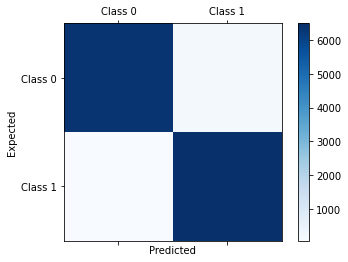

[0.         0.02551956 1.        ] [0.         0.99266392 1.        ] [2 1 0]


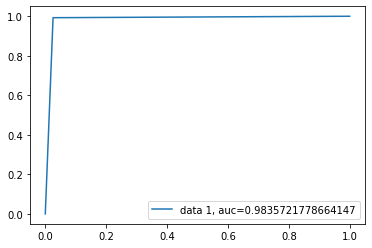

In [ ]:
split_and_model(dataset,['XGBClassifier', 'SMOTETomek', 'cumsum', 'EDA2'])

In [ ]:
dataset.sample(10)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum,numberOfRecentCancellations
89625,4176939744996,5.517637e+06,1.00000,1.459143e+09,1.463495e+09,32.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,50,0,1,5,88,138,4.0,NaN
99625,46784193141591,5.702392e+06,0.00000,1.463312e+09,1.463369e+09,15.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174668,1,0,6,0,11,136,137,11.0,NaN
2852,11729651891865,5.733943e+06,1.00000,1.464101e+09,1.464048e+09,79.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,1,-1,1,1,14,145,145,1.0,NaN
291,71724519836714,5.702852e+06,1.00000,1.463404e+09,1.463357e+09,44.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0,-1,0,0,13,137,137,0.0,NaN
84813,44434126230474,5.701909e+06,1.00000,1.463270e+09,1.463881e+09,11.260396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.662376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.337624,1,7,5,6,23,135,143,1.0,NaN
30672,47528677815653,5.775333e+06,1.00000,1.465205e+09,1.465344e+09,62.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,1,0,2,9,158,160,0.0,NaN
106659,47368721874293,5.678518e+06,0.00239,1.462866e+09,1.463016e+09,6.038232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.997610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002390,1,1,1,3,7,131,133,1.0,NaN
98132,81117947934226,5.662081e+06,1.0000

In [ ]:
pd.options.display.max_rows=100

In [ ]:
dataset[dataset['PatientId']==46784193141591].sort_values('AppointmentDay')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum,numberOfRecentCancellations
130299,46784193141591,5.676816e+06,0.0,1.462688e+09,1.462647e+09,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,-1,6,5,6,129,128,1.0,NaN
100108,46784193141591,5.683973e+06,0.0,1.462875e+09,1.462839e+09,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,-1,1,1,10,131,131,2.0,NaN
118861,46784193141591,5.684583e+06,0.0,1.462889e+09,1.462854e+09,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,-1,1,1,14,131,131,3.0,NaN
81998,46784193141591,5.689694e+06,0.0,1.463012e+09,1.462979e+09,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,-1,3,2,0,133,132,4.0,NaN
63779,46784193141591,5.691871e+06,0.0,1.463061e+09,1.463011e+09,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,-1,3,3,13,133,133,4.0,NaN
65516,46784193141591,5.692074e+06,0.0,1.463063e+09,1.463011e+09,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,-1,3,3,14,133,133,4.0,NaN
88962,46784193141591,5.692996e+06,0.0,1.463091e+09,1.463059e+09,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,-1,3,3,22,133,133,5.0,NaN
19484,46784193141591,5.694442e+06,0.0,1.463129e+09,1.463098e+09,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
99637671331

In [ ]:
def numberOfRecentCancellations(data, patientID):
  temp = data[data['PatientId']==patientID].sort_values('AppointmentDay')
  #print(temp)
  last_index = 0
  for counter, i in enumerate(temp.index):
    #print('temp: ',temp.loc[i]['cumsum'])
    if temp.loc[i, 'No-show'] == 1:
      temp2 = temp.assign(cumsum=temp['No-show'][last_index:].cumsum())
      data.loc[i, 'numberOfRecentCancellations']= temp2.loc[i]['cumsum']-1
    if temp.loc[i, 'No-show'] == 0:  
      last_index = counter

In [ ]:
temp['No-show'][last_index:]

Series([], Name: No-show, dtype: int64)

In [ ]:
numberOfRecentCancellations(46784193141591)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
dataset[dataset['PatientId']==46784193141591].sort_values('AppointmentDay')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum,numberOfRecentCancellations
130299,46784193141591,5.676816e+06,0.0,2016-05-08 06:18:30.994534,2016-05-07 18:51:41.506298,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,-1,6,5,6,129,128,0,0.0
100108,46784193141591,5.683973e+06,0.0,2016-05-10 10:05:27.587130,2016-05-10 00:13:47.208521,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,-1,1,1,10,131,131,0,1.0
118861,46784193141591,5.684583e+06,0.0,2016-05-10 14:06:53.534766,2016-05-10 04:18:29.281266,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,-1,1,1,14,131,131,0,2.0
81998,46784193141591,5.689694e+06,0.0,2016-05-12 00:21:09.533107,2016-05-11 15:05:55.985188,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,-1,3,2,0,133,132,0,3.0
63779,46784193141591,5.691871e+06,0.0,2016-05-12 13:52:00.000000,2016-05-12 00:00:00.000000,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,-1,3,3,13,133,133,0,NaN
65516,46784193141591,5.692074e+06,0.0,2016-05-12 14:22:09.000000,2016-05-12 00:00:00.000000,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,-1,3,3,14,133,133,0,NaN
88962,46784193141591,5.692996e+06,0.0,2016-05-12 22:13:04.238508,2016-05-12 13:16:29.253947,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000

In [ ]:
dataset2= dataset
dataset2

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum,numberOfRecentCancellations
0,468148177676828,5.401357e+06,0.000000,2016-02-26 10:14:28.000000,2016-05-24 00:00:00.000000,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,87,4,1,10,57,145,0,NaN
1,74734263232929,5.612074e+06,1.000000,2016-04-25 07:54:20.000000,2016-05-16 00:00:00.000000,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,20,0,0,7,116,137,0,NaN
2,79722691475274,5.682365e+06,0.000000,2016-05-10 16:22:16.000000,2016-06-02 00:00:00.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,22,1,3,16,131,154,0,NaN
3,94134943513475,5.640253e+06,1.000000,2016-04-29 10:23:53.000000,2016-05-13 00:00:00.000000,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,13,4,4,10,120,134,0,NaN
4,38811181658754,5.647384e+06,0.000000,2016-05-02 13:31:29.000000,2016-06-02 00:00:00.000000,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0,30,0,3,13,123,154,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4975919651957,5.639329e+06,1.000000,2016-04-29 08:53:39.086081,2016-06-02 22:50:58.486004,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
for i in uniquePatientID:
  numberOfRecentCancellations(i)

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-

In [ ]:
dataset['numberOfRecentCancellations'].fillna(0, inplace = True)
dataset

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum,numberOfRecentCancellations
0,468148177676828,5.401357e+06,0.000000,2016-02-26 10:14:28.000000,2016-05-24 00:00:00.000000,33.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,87,4,1,10,57,145,0,0.0
1,74734263232929,5.612074e+06,1.000000,2016-04-25 07:54:20.000000,2016-05-16 00:00:00.000000,41.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,20,0,0,7,116,137,0,0.0
2,79722691475274,5.682365e+06,0.000000,2016-05-10 16:22:16.000000,2016-06-02 00:00:00.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,1.000000,0,22,1,3,16,131,154,0,0.0
3,94134943513475,5.640253e+06,1.000000,2016-04-29 10:23:53.000000,2016-05-13 00:00:00.000000,32.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.000000,1,13,4,4,10,120,134,0,0.0
4,38811181658754,5.647384e+06,0.000000,2016-05-02 13:31:29.000000,2016-06-02 00:00:00.000000,63.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0000,0.0,1.000000,0,30,0,3,13,123,154,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130869,4975919651957,5.639329e+06,1.000000,2016-04-29 08:53:39.086081,2016-06-02 22:50:58.486004,1.041682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
#date
dataset['ScheduledDay'] = dataset['ScheduledDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
dataset['ScheduledDay'] = dataset['ScheduledDay'].apply(lambda x: datetime.timestamp(x))

dataset['AppointmentDay'] = dataset['AppointmentDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
dataset['AppointmentDay'] = dataset['AppointmentDay'].apply(lambda x: datetime.timestamp(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

[1 0 1 ... 1 1 1]
Accuracy: 91.19%
 f1  0.9038926398266233 
 recall 0.8286718630597585 
 precision 0.9941327466079941
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-569
Confusion matrix:
 [[6512   32]
 [1121 5422]]


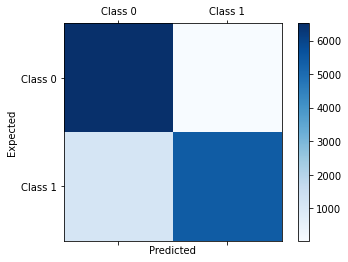

[0.         0.00488998 1.        ] [0.         0.82867186 1.        ] [2 1 0]


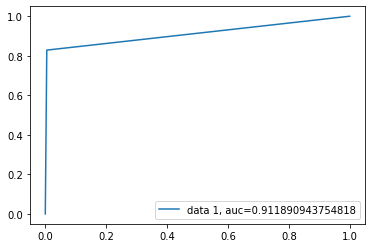

In [ ]:
split_and_model(dataset,['XGBClassifier', 'SMOTETomek', 'numberOfRecentCancellations', 'EDA2'])

In [ ]:
def run_model(model,X_train, y_train, X_test,y_test, val, name, tags):
    X_val = val.loc[:, val.columns != 'No-show']
    y_val = val["No-show"]

    neptune.create_experiment(
        name=name
    )
    
    model = train_model(model, X_train, y_train)
    y_pred = predict_model(model, X_test)
    val_pred = predict_model(model, X_val)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    print("Test")
    print(y_pred,'\n')
    print('accuracy: ', accuracy)
    print('recall: ',recall)
    print('precision: ', precision)
    print('f1: ', f1)
    print('ROC AUC: ', roc,'\n')
    print(classification_report(y_test, y_pred))


    accuracy_val = accuracy_score(y_val, val_pred)
    recall_val = recall_score(y_val, val_pred)
    precision_val = precision_score(y_val, val_pred)
    f1_val = f1_score(y_val, val_pred)
    roc_val = roc_auc_score(y_val, val_pred)

    print("Validation")
    print(val_pred,'\n')
    print('accuracy: ', accuracy_val)
    print('recall: ',recall_val)
    print('precision: ', precision_val)
    print('f1: ', f1_val)
    print('ROC AUC: ', roc_val,'\n')
    print(classification_report(y_val, val_pred))
    
    neptune.log_metric('accuracy', accuracy_val)
    neptune.log_metric('recall', recall_val)
    neptune.log_metric('precision', precision_val)
    neptune.log_metric('f1', f1_val)
    neptune.log_metric('roc_auc', roc_val)
    neptune.append_tags(tags)
    neptune.append_tags(name)
    neptune.append_tags("Validation")
    neptune.append_tags(["Magdalena Cebula"])
    
    plot_confusion_matrix(model, X_val, y_val, cmap='Blues');    
    plt.show()
#    plot_learning_curve(model, X_val, y_val, scoring='f1');    
    plt.show()
    neptune.stop()

In [ ]:
x_val['No-show'] = y_val

In [ ]:
x_val

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
74732,62166383748496,5686941,1,1.462976e+09,1.463098e+09,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
46099,6529855591596,5682800,0,1.462908e+09,1.462838e+09,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
58059,2314564212973,5673355,1,1.462785e+09,1.462752e+09,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43393,98542625315963,5710655,0,1.463505e+09,1.463443e+09,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30578,7881337869312,5741628,1,1.464593e+09,1.464566e+09,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8463,33534783483176,5738875,0,1.464177e+09,1.464134e+09,44,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
50126,31693127444723,5647062,0,1.462193e+09,1.462147e+09,59,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
107486,15338272715796,5782509,0,1.465299e+09,1.465258e+09,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
91756,55336915167382,5730109,1,1.464077e+09,1.465258e+09,50,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
val2 = x_val

In [ ]:
val2

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
74732,62166383748496,5686941,1,1.462976e+09,1.463098e+09,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
46099,6529855591596,5682800,0,1.462908e+09,1.462838e+09,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
58059,2314564212973,5673355,1,1.462785e+09,1.462752e+09,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43393,98542625315963,5710655,0,1.463505e+09,1.463443e+09,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30578,7881337869312,5741628,1,1.464593e+09,1.464566e+09,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8463,33534783483176,5738875,0,1.464177e+09,1.464134e+09,44,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
50126,31693127444723,5647062,0,1.462193e+09,1.462147e+09,59,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
107486,15338272715796,5782509,0,1.465299e+09,1.465258e+09,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
91756,55336915167382,5730109,1,1.464077e+09,1.465258e+09,50,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# #date
# x_val['ScheduledDay'] =  x_val['ScheduledDay'].apply(lambda x: datetime.fromtimestamp(x))
# x_val['AppointmentDay'] =  x_val['AppointmentDay'].apply(lambda x: datetime.fromtimestamp(x))

# x_val['Waiting_Time_days'] = x_val['AppointmentDay'] - x_val['ScheduledDay']
# x_val['Waiting_Time_days'] = x_val['Waiting_Time_days'].dt.days
# x_val = x_val[x_val['Waiting_Time_days'] >=-1]

# x_val['ScheduledWeekday'] = x_val['ScheduledDay'].dt.dayofweek
# x_val['AppointmentWeekday'] = x_val['AppointmentDay'].dt.dayofweek

# x_val['ScheduledHour'] = x_val['ScheduledDay'].dt.hour

# x_val['ScheduledDay_in_year'] = x_val['ScheduledDay'].apply(lambda x: x.timetuple().tm_yday)
# x_val['AppointmentDay_in_year'] = x_val['AppointmentDay'].apply(lambda x: x.timetuple().tm_yday)

# uniqueValPatientID = x_val['PatientId'].unique()
# uniqueValPatientID

for i in uniqueValPatientID:
  numberOfRecentCancellations(x_val, i)


In [ ]:
x_val['numberOfRecentCancellations'].fillna(0, inplace=True)
x_val

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,numberOfRecentCancellations
74732,62166383748496,5686941,1,2016-05-11 14:21:19,2016-05-13,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,4,14,132,134,0.0
46099,6529855591596,5682800,0,2016-05-10 19:27:20,2016-05-10,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,1,19,131,131,0.0
58059,2314564212973,5673355,1,2016-05-09 09:13:44,2016-05-09,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,9,130,130,0.0
43393,98542625315963,5710655,0,2016-05-17 17:04:36,2016-05-17,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,1,17,138,138,0.0
30578,7881337869312,5741628,1,2016-05-30 07:16:42,2016-05-30,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,7,151,151,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8463,33534783483176,5738875,0,2016-05-25 11:49:55,2016-05-25,44,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-1,2,2,11,146,146,0.0
50126,31693127444723,5647062,0,2016-05-02 12:40:40,2016-05-02,59,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,12,123,123,0.0
107486,15338272715796,5782509,0,2016-06-07 11:29:16,2016-06-07,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,1,11,159,159,0.0
91756,55336915167382,5730109,1,2016-05-24 08:09:59,2016-06-07,50,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,13,1,1,8,145,159,0.0


In [ ]:
x_val.drop("ScheduledDay", inplace = True, axis=1)

In [ ]:
x_val.drop("AppointmentDay", inplace = True, axis=1)

In [ ]:
x_val.drop("AppointmentID", inplace = True, axis=1)

In [ ]:
x_val.drop("PatientId", inplace = True, axis=1)

In [ ]:
x_val

,Gender,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,Neighbourhood_35,Neighbourhood_36,Neighbourhood_37,Neighbourhood_38,...,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,numberOfRecentCancellations
74732,1,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,4,14,132,134,0.0
46099,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,1,19,131,131,0.0
58059,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,9,130,130,0.0
43393,0,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,1,17,138,138,0.0
30578,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,7,151,151,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8463,0,44,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-1,2,2,11,146,146,0.0
50126,0,59,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,12,123,123,0.0
107486,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,1,11,159,159,0.0
91756,1,50,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,13,1,1,8,145,159,0.0


In [ ]:
def split_and_model_val(data, tags):
  X = data.loc[:, data.columns != 'No-show']
  X.tail()
  Y = data["No-show"]
  Y.tail()
  #data.drop("cumsum", inplace = True, axis=1)
  #data.drop("PatientId", inplace = True, axis=1)

  #data.drop("AppointmentID", inplace = True, axis=1)

  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, train_size=0.9, random_state=0, stratify=Y, shuffle=True)
  run_model(clf, X_train, y_train, X_test,y_test, x_val, 'XGBClassifier', tags)


In [ ]:
def train_model(model, X, y):
    model.fit(X, y)
    return model

def predict_model(model, X):
    y_pred = model.predict(X)
    return y_pred

def score_model(y_test, y_pred, scoring):
    score = scoring(y_test, y_pred)
    return score

def train_and_predict(model, X, y, scoring):
    scores = cross_val_score(model, X, y, cv = 7, scoring = scoring)
    return np.mean(scores), np.std(scores)

https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-581
Test
[1 0 1 ... 1 1 1] 

accuracy:  0.9120501260793153
recall:  0.8410515054256458
precision:  0.9802280014250089
f1:  0.9053220366866827
ROC AUC:  0.9120447013680796 

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      6544
           1       0.98      0.84      0.91      6543

    accuracy                           0.91     13087
   macro avg       0.92      0.91      0.91     13087
weighted avg       0.92      0.91      0.91     13087

Validation
[0 0 0 ... 0 0 0] 

accuracy:  0.7973400886637112
recall:  0.06003584229390681
precision:  0.4855072463768116
f1:  0.10685805422647526
ROC AUC:  0.5219689471077289 

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      8821
           1       0.49      0.06      0.11      2232

    accuracy                           0.80     11053
   macro avg       0

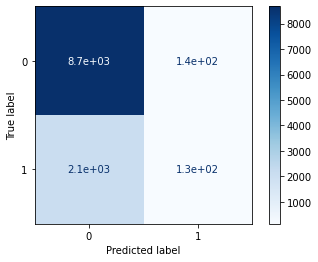

In [ ]:
split_and_model_val(dataset,['XGBClassifier', 'SMOTETomek', 'numberOfRecentCancellations', 'Validation', 'EDA2'])

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


In [ ]:
def split_and_model_val(data, tags):
  X = data.loc[:, data.columns != 'No-show']
  X.tail()
  Y = data["No-show"]
  Y.tail()
  #data.drop("cumsum", inplace = True, axis=1)
  #data.drop("PatientId", inplace = True, axis=1)

  #data.drop("AppointmentID", inplace = True, axis=1)
  clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, train_size=0.9, random_state=0, stratify=Y, shuffle=True)
  run_model(clf, X_train, y_train, X_test,y_test, x_val, 'GradientBoostingClassifier', tags)

https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-583
Test
[1 0 1 ... 1 1 1] 

accuracy:  0.9120501260793153
recall:  0.8410515054256458
precision:  0.9802280014250089
f1:  0.9053220366866827
ROC AUC:  0.9120447013680796 

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      6544
           1       0.98      0.84      0.91      6543

    accuracy                           0.91     13087
   macro avg       0.92      0.91      0.91     13087
weighted avg       0.92      0.91      0.91     13087

Validation
[0 0 0 ... 0 0 0] 

accuracy:  0.7973400886637112
recall:  0.06003584229390681
precision:  0.4855072463768116
f1:  0.10685805422647526
ROC AUC:  0.5219689471077289 

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      8821
           1       0.49      0.06      0.11      2232

    accuracy                           0.80     11053
   macro avg       0

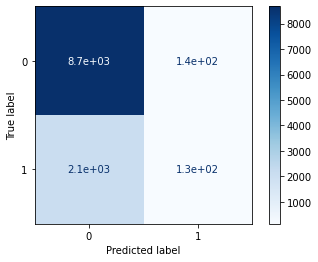

In [ ]:
split_and_model_val(dataset,['GradientBoostingClassifier', 'SMOTETomek', 'numberOfRecentCancellations', 'Validation', 'EDA2'])